# Investigating Backprop, and Hopfield Networks

In [1]:
# Standard imports
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import Network as Network
import copy

# Q1: Vanishing Gradient

## (a)

Since $max(\sigma ^ \prime (.)) = \frac {1}{4}$, the given expression is true just when $|w|\geq 4$.

## (b)

$$
\begin{align}
    \sigma ^ \prime(wh) &\geq \frac{1}{|w|} \\
    \frac{e ^ {-wh}}{(1 + e ^ {-wh}) ^ 2} &\geq \frac{1}{|w|} \\ 
    (e ^ {-wh}) ^ 2 + (2 - |w|) e^{-wh} + 1 &\leq 0
\end{align}
$$
Lets $x =e ^ {-wh}$ ; 
$$
\begin{align}
    x ^ 2 + (2 - |w|) x + 1 &\leq 0
\end{align}
$$

Sine $|w| \geq 4$ then $\Delta > 0$ and the eaquation has two real roots, $r_1$ & $r_2$ ;

$$
\begin{align}
    r_1, r_2 &= \frac{|w| \big(1 \pm \sqrt{1 - \frac{4}{|w|}}\big)}{2} - 1 \\
    r_1 &\leq x \leq r_2 \\
    r_1 &\leq e ^ {-wh} \leq r_2
\end{align}
$$
if $w>0$ then; 
$$
\begin{align}
    \frac{-1}{w}lnr_2 &\leq h \leq \frac{-1}{w}lnr_1
\end{align}
$$
So the width of interval will be; 
$$
\begin{align}
|\frac{-1}{w}(-lnr_1 + lnr_2)| &= |\frac{-1}{w}ln\frac{r_2}{r_1}| = \frac{1}{|w|}ln\frac{r_2}{r_1}  &      (1)
\end{align}
$$
for $w<0$ the result will be the same.

Based on Vieta's formulas the roots of quadratic equation $ax^2 + bx + c=0$ satify $r_1 r_2 = \frac{c}{a}$.

So for our case $\frac{r_2}{r_1} = r_2 ^ 2$. Then the width of interval where $h$ resides will be;

$$
\begin{align}
\frac{2}{|w|}lnr_2 &= \frac{2}{|w|} ln\bigg[\frac{|w|}{2} \bigg(1 + \sqrt{1 - \frac{4}{|w|}}\bigg) - 1 \bigg]
\end{align}
$$

## (c) Plots

In [ ]:
# [1] Evaluate expression
def blah(w):
    aw = abs(w)
    v = 2./aw * np.log( (aw*(1+np.sqrt(1-4./aw)))/2. - 1 )
    return v

In [ ]:
# [1] Evaluate and plot expression
w = np.linspace(4.1, 15, 200)
v = [blah(ww) for ww in w]
plt.plot(w,v)
plt.xlabel(r'$|w|$')
plt.ylabel('Width of values');

In [ ]:
# [1] Show that peak is around 6.9
w = np.linspace(6.8,7,50)
v = [blah(ww) for ww in w]
plt.plot(w,v)
plt.xlabel(r'$|w|$')
plt.ylabel('Width of values');

# Q2: Weight Decay

## Helper code

### Dataset

In [2]:
def GenerateDatasets(n, seed=None):
    # 1D -> 1D (line mapping)
    n_input = 1
    n_output = 1
    noise = 0.5

    if seed:
        np.random.seed(seed)
    a = np.random.rand()
    m = np.random.rand() + 0.5
    b = np.random.rand()-0.5

    def myfunc(x):
        return a*x**2 + m*x + b

    # Create a training dataset
    n_samples = n
    training_output = []
    training_input = []
    xv = np.linspace(-1, 1, n_samples)
    for idx in range(n_samples):
        #x = np.random.rand()*2. - 1.
        x = xv[idx]
        t = myfunc(x) + np.random.normal(scale=noise)
        training_input.append(np.array([x]))
        training_output.append(np.array([t]))

    # Create a testing dataset
    test_input = []
    test_output = []
    n_test_samples = 300
    xv = np.linspace(-1, 1, n_test_samples)
    for idx in range(n_test_samples):
        #x = np.random.rand()*2. - 1.
        x = xv[idx] #+ np.random.normal(scale=0.1)
        t = myfunc(x) + np.random.normal(scale=noise)
        test_input.append(np.array([x]))
        test_output.append(np.array([t]))


    train = [np.array(training_input), np.array(training_output)]
    test = [np.array(test_input), np.array(test_output)]
    
    return train, test

### Sample Code

In [8]:
# Here is an example, creating a Network object.
import importlib
importlib.reload(Network)
net = Network.Network([1,6,1], type='regression')

In [9]:
# Generate the training and testing datasets
train, test = GenerateDatasets(50, seed=3502)

In [10]:
# Train the network
progress = net.SGD(train[0], train[1], epochs=100, lrate=1.)

In [11]:
# Evaluate the cost 
print('Training cost = '+str(net.Evaluate(train[0], train[1])))
print('    Test cost = '+str(net.Evaluate(test[0], test[1])))

# These results won't necessarily make sense, since the network model
# might not be the right choice for the dataset.

Training cost = 0.09234415077873445
    Test cost = 0.1538454361686255


## (a) Implement weigth decay in `BackProp`

In [19]:
class RobustNetwork(Network.Network):
        
    def BackProp(self, t, lrate=0.05, decay=0.):
        '''
            net.BackProp(targets, lrate=0.05, decay=0.)
            
            Given the current network state and targets t, updates the connection
            weights and biases using the backpropagation algorithm.
            
            Inputs:
             t      an array of targets (number of samples must match the
                    network's output)
             lrate  learning rate
             decay  is the coefficient for weight/bias decay
        '''
            
        t = np.array(t)  # convert t to an array, in case it's not

        # Error gradient for top layer (same for both types)
        dEdz = self.TopGradient(t)

        # Loop down through the layers
        # Start second-from-the-top, and go down to layer 0
        for i in range(self.n_layers-2, -1, -1):
            pre = self.lyr[i]

            # Gradient w.r.t. weights
            dEdW = pre.h.T @ dEdz

            # Gradient w.r.t. biases
            dEdb = np.sum(dEdz, axis=0)

            # Use Sigma'
            # Project error gradient down to layer below
            dEdz = ( dEdz @ self.W[i].T ) * pre.sigma_p()

            # Update weights and biases
            self.W[i] -= lrate * (dEdW + 2 * decay * self.W[i]) 
            self.lyr[i+1].b -= lrate * (dEdb + 2 * decay * self.lyr[i+1].b)
            

    
    def SGD(self, inputs, targets, lrate=0.05, epochs=1, batch_size=10, decay=0):
        '''
            progress = net.SGD(inputs, targets, lrate=0.05, epochs=1, batch_size=10, decay=0)

            Performs Stochastic Gradient Descent on the network.
            Run through the dataset in batches 'epochs' number of times, incrementing the
            network weights after each batch. For each epoch, it shuffles the dataset.

            Inputs:
              inputs  is an array of input samples
              targets is a corresponding array of targets
              lrate   is the learning rate (try 0.001 to 5)
              epochs  is the number of times to go through the training data
              batch_size is the number of samples for each batch
              decay   is the decay coefficient for the weights and biases
              
            Outputs:
              progress is an (epochs)x2 array with epoch in the first column, and 
                      cost in the second column
        '''
        loss_history = []
        for k in range(epochs):
            batches = Network.MakeBatches(inputs, targets, batch_size=batch_size, shuffle=True)
            for mini_batch in batches:
                self.FeedForward(mini_batch[0])
                self.BackProp(mini_batch[1], lrate=lrate, decay=decay)

            loss_history.append([k, self.Evaluate(inputs, targets)])

        return np.array(loss_history)


## (b) Create the Network

In [64]:
# Create a RobustNetwork, using MSE and identity output
original_net = RobustNetwork([1,10,1], type='regression')
decay_net = copy.deepcopy(original_net)
# Make copies -> original_net, dropout_net


## (c) Generate a dataset, and train net _without_ decay

In [65]:
# Generate the training and testing datasets
P = 5
train, test = GenerateDatasets(P)

In [66]:
# [1] Train using SGD (batch_size argument is optional on such a small dataset)
progress_original = original_net.SGD(train[0], train[1], lrate=0.1, epochs=5000, batch_size=1, decay=0)

In [67]:
# Evaluate on both datasets
print('Training cost for Original Net. = '+str(original_net.Evaluate(train[0], train[1])))
print('    Test cost for Original Net. = '+str(original_net.Evaluate(test[0], test[1])))

Training cost for Original Net. = 0.016976204588342085
    Test cost for Original Net. = 0.1726484072079197


## (d) Train net _with_ decay

In [68]:
# Train with dropout, and evaluate
progress_decay = decay_net.SGD(train[0], train[1], lrate=0.1, epochs=5000, batch_size=1, decay=0.03)

print('Training cost for Decay Net. = '+str(decay_net.Evaluate(train[0], train[1])))
print('    Test cost for Decay Net. = '+str(decay_net.Evaluate(test[0], test[1])))

Training cost for Decay Net. = 0.10205110834738976
    Test cost for Decay Net. = 0.23689522119739584


## (e) Plot training data and models

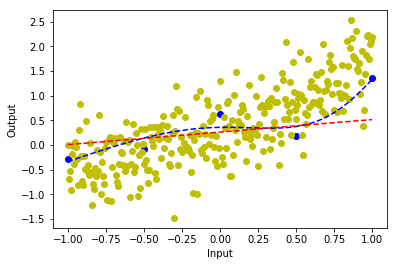

In [92]:
# Plot Training and Test data
plt.plot(train[0],train[1] ,'bo')
plt.plot(test[0],test[1] ,'yo')

x = np.linspace(-1, 1, 100)
original_output = [original_net.FeedForward([xx]) for xx in x]
decay_output = [decay_net.FeedForward([xx]) for xx in x]

plt.plot(x,original_output ,'b--')
plt.plot(x,decay_output ,'r--')

plt.xlabel('Input');plt.ylabel('Output');

#plt.legend()
# Plot original_net and dropout_net models


## (f) Average performance over 10 datasets

In [101]:
# Loop for 10 trials
trials = 10

orig_train = []
orig_test = []
decay_train = []
decay_test = []

for k in range(trials):
    original_net = RobustNetwork([1,10,1], type='regression')
    decay_net = copy.deepcopy(original_net)
    
    train, test = GenerateDatasets(P)
    
    # Training
    original_net.SGD(train[0], train[1], lrate=0.1, epochs=5000, batch_size=1, decay=0)
    decay_net.SGD(train[0], train[1], lrate=0.1, epochs=5000, batch_size=1, decay=0.03)
    
    orig_train.append(original_net.Evaluate(train[0], train[1]))
    decay_train.append(decay_net.Evaluate(train[0], train[1]))

    orig_test.append(original_net.Evaluate(test[0], test[1]))
    decay_test.append(decay_net.Evaluate(test[0], test[1]))
    
    print(k)

0
1
2
3
4
5
6
7
8
9


In [102]:
# Compute the mean cost over the 10 trials

orig_train_ave = np.sum(orig_train) / len(orig_train) 
decay_train_ave = np.sum(decay_train) / len(decay_train) 

orig_test_ave = np.sum(orig_test) / len(orig_test)  
decay_test_ave = np.sum(decay_test) / len(decay_test) 

print('Training set, without decay,   cost = '+str(orig_train_ave))
print('Training set, with decay=0.03, cost = '+str(decay_train_ave))
print('Test set,     without decay,   cost = '+str(orig_test_ave))
print('Test set,     with decay=0.03, cost = '+str(decay_test_ave))

Training set, without decay,   cost = 0.0007785658367116921
Training set, with decay=0.03, cost = 0.22107886209563143
Test set,     without decay,   cost = 0.2780565026693358
Test set,     with decay=0.03, cost = 0.24178259590559245


I prefer the model with decay because the test accuarcy is almost the same as the wothout-decay model but it is less probable to overfit. 

# Q3: Classifier Networks

## Helper code

In [104]:
def ClassPlot(x, y):
    # FeedForward
    yc = Network.OneHot(y)
    colour_options = ['y', 'b', 'r', 'g', 'k']
    cidx = np.argmax(yc, axis=1)
    colours = [colour_options[k] for k in cidx]
    plt.scatter(x[:,0],x[:,1], color=colours, marker='.')
    plt.axis('equal');

def GaussianCluster(mu, sa, N, theta=0.):
    theta_rad = theta/180*np.pi
    c, s = np.cos(theta_rad), np.sin(theta_rad)
    R = np.array([[c,-s],[s,c]])
    M = R @ np.diag(sa) @ R.T
    y = np.random.multivariate_normal(mu, M, N)
    return y

def CreateDataset(params):
    '''
        train, test = CreateDataset(params)
        
        Creates a dataset using a bunch of Gaussian clouds.
        
        Inputs:
          params is a list of 5-tuples. Each tuple (or list)
             describes a 2-D Gaussian cloud:
             1) the mean
             2) standard deviation along x and y directions
             3) rotation of cloud (degrees counter-clockwise)
             4) class index
             5) number of points
             
        Outputs:
          train is a list containing 2 arrays
             - the first array contains the training inputs,
               one per row
             - the second array contains the corresponding classes
          test has the same structure as train, but with
               half the number of samples
    '''
    train_inputs = []
    train_outputs = []
    test_inputs = []
    test_outputs = []
    all_c = [p[3] for p in params]
    n_classes = np.max(all_c)
    for p in params:
        xx = GaussianCluster(p[0], p[1], p[4], theta=p[2])
        yy = np.zeros((p[4], n_classes+1))
        yy[:,p[3]] = 1.
        train_inputs.append(xx)
        train_outputs.append(yy)
        xtest = GaussianCluster(p[0], p[1], int(p[4]/2), theta=p[2])
        ytest = np.zeros((int(p[4]/2), n_classes+1))
        ytest[:,p[3]] = 1.
        test_inputs.append(xtest)
        test_outputs.append(ytest)
    train = [np.vstack(train_inputs), np.vstack(train_outputs)]
    test = [np.vstack(test_inputs), np.vstack(test_outputs)]
    return train, test

# 0=y, 1=b, 2=r
params = [[[0.5, 0.5],   [0.025, 0.01],  -45, 0, 50],
          [[-0.5,-0.5],  [0.025, 0.01],  -45, 0, 50],
          [[-0.3,-0.35], [0.04,0.01],     10, 0, 80],
          [[0.6,0],      [0.01,0.01],      0, 0, 50],
          [[0.1,-0.04],  [0.1,0.005],     20, 0, 80],
          [[0.5,-0.5],   [0.02,0.01],     45, 1, 50],
          [[0,0.6],      [0.01,0.01],      0, 1, 50],
          [[-0.5,0.1],   [0.02,0.01],     30, 1, 80],
          [[-0.5,0.5],   [0.02,0.01],     45, 2, 50],
          [[0,-0.6],     [0.01,0.01],      0, 2, 50],
          [[0.2,0.3],    [0.01,0.004],     0, 2, 80],
          [[-0.2,0.37],  [0.02,0.005],   -30, 2, 50],
          [[0.25,-0.3],  [0.005,0.01],     0, 3, 60],
          [[-0.1,0.1],   [0.01,0.01],    -30, 3, 50]
         ]

In [105]:
# Create an interesting dataset
train, test = CreateDataset(params)

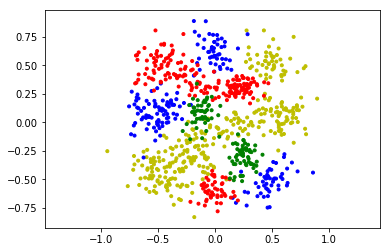

In [106]:
ClassPlot(train[0], train[1]);

## (a) `TopGradient`

In [108]:
class ExtNetwork(Network.Network):
    
    def TopGradient(self, t):
        '''
            dEdz = net.TopGradient(targets)

            Computes and returns the gradient of the cost with respect to the input current
            to the output nodes.

            Inputs:
              targets is a batch of targets corresponding to the last FeedForward run

            Outputs:
              dEdz is a batch of gradient vectors corresponding to the output nodes
        '''
        P = len(t)
        if self.type=='Bernoulli':
            return ( self.lyr[-1].h - t ) / P
        elif self.type=='regression':
            return ( self.lyr[-1].h - t ) / P
        elif self.type=='classifier':
            return ( self.lyr[-1].h - t ) / P
        else:
            return self.gradLoss(self.lyr[-1].h, t) * self.lyr[-1].sigma_p()


## (b) Create and Evaluate a Neural Network

In [109]:
# Create a network that can solve the problem
classifier_net = ExtNetwork([2,10,4], type='classifier')

In [110]:
train, test = CreateDataset(params)

In [111]:
# Train and evaluate the model
progress = classifier_net.SGD(train[0], train[1], epochs=400, lrate=0.5)

## (c) Evaluate Model

In [112]:
# Classification accuracy on training and test datasets
classifier_net.ClassificationAccuracy(train[0], train[1])

0.9060240963855422

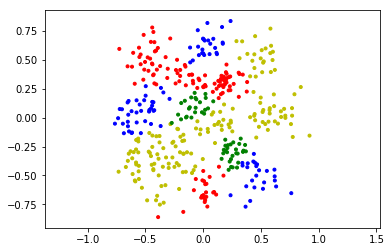

In [114]:
# Plot coloured clouds
ClassPlot(test[0], classifier_net.FeedForward(test[0]));

# Q4: Hopfield Network

## Helper code

In [4]:
# The next line sets the default for the number of significant digits to display.
np.set_printoptions(precision=4)

# Utility functions
def HammingDist(a, b):
    '''
     d = HammingDist(a, b)
     
     Returns the Hamming distance between 'a' and 'b'.
     The Hamming distance is the number of elements with opposite signs.
     eg. HammingDist([1,1,-1], [-1,1,-1])  -> 1
         HammingDist([0.5, -0.1, 1.4], [1, -0.9, 0.1])  -> 0
    '''
    return np.sum(np.array(a)*np.array(b)<0.)

def sigma(x):
    return np.tanh(x)

def sigma_inv(y):
    return 0.5 * ( np.log(1.+y) - np.log(1.-y) )

# Functions for creating a dataset
def Sample(Y, flip=-0.5):
    '''
     yy, ytrue = Sample(Y, flip=-0.5)
     
     Draw a sample randomly from Y.
     With probability 'flip', the sample is contaminated by flipping bits.
     If flip is positive, the each bit will be flipped with probability 'flip'.
     If flip is negative, then a single random bit will be flipped with prob '-flip'.
     eg. flip 1st bit: [1,-1,1,1] -> [-1,-1,1,1]
     
     Returns:
       yy     the (potentially contaminated) sample
       ytrue  the corresponding uncontaminated sample
    '''
    # Choose one of the prototpyes
    idx = np.random.randint(len(Y))
    yy = copy.deepcopy(Y[idx])
    ytrue = copy.deepcopy(yy)
    
    # Contaminate it
    if flip<0:
        r = np.random.rand()
        if r<abs(flip):
            k = np.random.randint(len(yy)) # Choose random bit
            yy[k] *= -1.   # Flip it!
        
    else:
        # Flip each bit with prob 'flip'
        for k,_ in enumerate(yy):
            r = np.random.rand()
            if r<flip:
                yy[k] *= -1.
    return yy, ytrue

def MakeDataset(Y, N=1000, flip=-0.5):
    '''
     Yd, Ytrue = MakeDataset(Y, N=1000, flip=-0.5)
     
     Creates a dataset of N samples by sampling the prototypes in Y.
     For each sample, there is a probability of 'flip' that the sample
     will be contaminated (see Sample function).
     
     Returns:
       Yd     the (potentially contaminated) dataset
       Ytrue  the corresponding uncontaminated dataset
    '''
    Yd = []
    Ytrue = []
    for n in range(N):
        yy, ytrue = Sample(Y, flip=flip)
        Yd.append(yy)
        Ytrue.append(ytrue)
    Yd = np.array(Yd)
    Ytrue = np.array(Ytrue)
    return Yd, Ytrue

### Actual Dataset

In [5]:
# Make a dataset of memories
Y = np.array([[1,0,0,1,1,0,0,1],
              [0,1,0,1,0,1,0,1],
              [1,1,1,0,1,0,1,0],
              [0,0,1,0,0,1,1,0]])
m = 0.99
Y = m*(2.*Y - 1.)

In [6]:
Y

array([[ 0.99, -0.99, -0.99,  0.99,  0.99, -0.99, -0.99,  0.99],
       [-0.99,  0.99, -0.99,  0.99, -0.99,  0.99, -0.99,  0.99],
       [ 0.99,  0.99,  0.99, -0.99,  0.99, -0.99,  0.99, -0.99],
       [-0.99, -0.99,  0.99, -0.99, -0.99,  0.99,  0.99, -0.99]])

In [7]:
# Here is how you can generate 1 (noisy/clean) sample
yy, ytrue = Sample(Y, flip=0.1)
HammingDist(yy, ytrue)

1

In [8]:
# Here is how you can create a (noisy and clean) dataset
Yd, Ytrue = MakeDataset(Y, N=10, flip=-0.5)
print(Yd)
print(Ytrue)

[[-0.99  0.99  0.99 -0.99  0.99 -0.99  0.99 -0.99]
 [-0.99 -0.99  0.99 -0.99  0.99  0.99  0.99 -0.99]
 [ 0.99  0.99  0.99 -0.99  0.99 -0.99  0.99  0.99]
 [ 0.99 -0.99 -0.99 -0.99  0.99 -0.99 -0.99  0.99]
 [ 0.99 -0.99  0.99 -0.99 -0.99  0.99  0.99 -0.99]
 [-0.99  0.99 -0.99  0.99 -0.99  0.99  0.99  0.99]
 [-0.99  0.99  0.99  0.99 -0.99  0.99 -0.99  0.99]
 [-0.99  0.99 -0.99  0.99 -0.99  0.99 -0.99  0.99]
 [-0.99  0.99 -0.99  0.99 -0.99  0.99 -0.99  0.99]
 [ 0.99  0.99  0.99  0.99  0.99 -0.99  0.99 -0.99]]
[[ 0.99  0.99  0.99 -0.99  0.99 -0.99  0.99 -0.99]
 [-0.99 -0.99  0.99 -0.99 -0.99  0.99  0.99 -0.99]
 [ 0.99  0.99  0.99 -0.99  0.99 -0.99  0.99 -0.99]
 [ 0.99 -0.99 -0.99  0.99  0.99 -0.99 -0.99  0.99]
 [-0.99 -0.99  0.99 -0.99 -0.99  0.99  0.99 -0.99]
 [-0.99  0.99 -0.99  0.99 -0.99  0.99 -0.99  0.99]
 [-0.99  0.99 -0.99  0.99 -0.99  0.99 -0.99  0.99]
 [-0.99  0.99 -0.99  0.99 -0.99  0.99 -0.99  0.99]
 [-0.99  0.99 -0.99  0.99 -0.99  0.99 -0.99  0.99]
 [ 0.99  0.99  0.99 -0.99  0.9

## (a) Derive $\frac{\partial E}{\partial y_i}$

=== Your answer here ===

## (b) Derive $\frac{\partial E}{\partial x_i}$

=== Your answer here ===

## (c) Derive $\frac{\partial E}{\partial W_{ij}}$

=== Your answer here ===

## (d) Derive $\frac{\partial E}{\partial b_i}$

=== Your answer here ===

## (e)-(f) `HopfieldNet` class

In [9]:
class HopfieldNet(object):
    
    def __init__(self, N):
        self.N = N   # Number of nodes
        
        self.lambda_x = 0.1  # decay rate for x
        self.lambda_W = 0.1  # decay rate for W
        self.lambda_b = 0.1  # decay rate for b
        
        self.x = np.zeros(N)     # Node input currents
        self.b = np.zeros(N)     # Node biases
        self.W = np.zeros((N,N)) # Connection weights (symmetric)
        
        self.sigma = sigma          # Activation function
        self.sigma_inv = sigma_inv  # Inverse of activation function
    
    
    
    def Train(self, Y, epochs=100, dt=0.01):
        '''
         HopefieldNet.Train(Y, epochs=100, dt=0.01)
         
         Train the Hopfield network for epochs, choosing one sample at a time
         and using it update the connection weights and biases by taking a
         single Euler step of length dt.
        '''
        dEdW = np.zeros((self.N, self.N))
        dEdb = np.zeros(self.N) 
        
        for ep in range(epochs):
            Ys = copy.deepcopy(Y)
            np.random.shuffle(Ys)
            
            #=== YOUR CODE HERE ===
           
            for itr in range(len(Y)):
                _, ySample = Sample(Ys)
                
                for i in range(self.N):
                    for j in range(self.N):
                        if i < j:
                            dEdW[i][j] = 0.5 * (-ySample[i] * ySample[j]) + (self.lambda_W * self.W[i][j])
                        if i > j:
                             dEdW[i][j] = dEdW[j][i] 
                    
                    dEdb[i] = -ySample[i] + self.lambda_b * self.b[i]
                
                self.W -= dEdW * dt
                self.b -= dEdb * dt
        
    def Recall(self, T, dt, y):
        '''
         HopefieldNet.Recall(T, dt, y)
         
         Run the Hopfield network for T seconds, updating the node activities
         using Euler steps of length dt.
        '''
        self.x = copy.deepcopy(self.sigma_inv(y))
        t = 0.
        
        dEdx = np.zeros(self.N)
        
        for tt in range(int(T * 1/ dt)):       
            for i in range(self.N): 
                blah = 0.
                for j in range(self.N): 
                    blah += self.W[i][j] * y[j]
            
                dEdx[i] = (-blah - self.b[i] + self.lambda_x * self.x[i]) * (1 - y[i] ** 2)
            
            self.x -= dEdx * dt
            y = self.sigma(self.x)


## (g) Train and test the network

In [30]:
# Training dataset
_, Ytrain = MakeDataset(Y, N=1000, flip=0.1)
# Create the network
net = HopfieldNet(8)
# Train it
net.Train(Ytrain, epochs = 5, dt = 0.01)

### Test the network

In [28]:
Ytest,Ytrue = MakeDataset(Y, N=100, flip=0.1)

In [29]:
T = 5.
dt = 0.01
correct = 0
total = 0
for yy,ytrue in zip(Ytest, Ytrue):
    net.Recall(T, dt, yy)
    if HammingDist(ytrue, net.sigma(net.x))==0:
        correct += 1
    else:
        print('Error: Hamming Dist = '+str(HammingDist(yy, ytrue)))
    total += 1
print('Success rate = '+str(correct/total*100.)+'%')

Error: Hamming Dist = 2
Error: Hamming Dist = 4
Error: Hamming Dist = 2
Error: Hamming Dist = 3
Error: Hamming Dist = 1
Error: Hamming Dist = 1
Error: Hamming Dist = 1
Error: Hamming Dist = 1
Error: Hamming Dist = 1
Error: Hamming Dist = 1
Error: Hamming Dist = 2
Error: Hamming Dist = 1
Error: Hamming Dist = 2
Success rate = 87.0%


In [51]:
yy, ytrue = Sample(Y, flip=0.1)
net.Recall(T, dt, yy)
print('Hamming Distance = '+str(HammingDist(yy, ytrue)))
print(np.vstack((ytrue,yy,net.sigma(net.x))))
if not HammingDist(ytrue, net.sigma(net.x)): print('CORRECT')

Hamming Distance = 0
[[-0.99   -0.99    0.99   -0.99   -0.99    0.99    0.99   -0.99  ]
 [-0.99   -0.99    0.99   -0.99   -0.99    0.99    0.99   -0.99  ]
 [-0.9998 -0.992   1.     -1.     -0.9998  0.9998  1.     -1.    ]]
CORRECT
